#Prototypical Netwoks on the notMNIST data

*   `Author:` Dvir shaul, Samuel Harroch, Yehonatan Escojido, Adi Hoftman.
*   `Date:` 05/2022
*   `Credit:` Main source of inspiration [https://github.com/jakesnell/prototypical-networks](https://github.com/jakesnell/prototypical-networks)

##Import libraries

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import cv2

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from tqdm import tqdm_notebook
from tqdm import tnrange

In [2]:
#Check GPU support, please do activate GPU
print(torch.cuda.is_available())

True


##Read data

The notMNIST dataset contains 10 letters of the english alphabets with each contain 1832 expamples. 
It is split into a background set and We will use the background set for training and the evaluation set for testing.

In [3]:
def read_alphabets(alphabet_directory_path, alphabet_directory_name):
    """
    Reads all the characters from a given alphabet_directory
    """
    datax = []
    datay = []
    characters = os.listdir(alphabet_directory_path)   
    print(alphabet_directory_name)
    print(characters) 
    for character in characters:
        images = os.listdir(alphabet_directory_path + character + '/')
        for img in images:
            image = cv2.imread(alphabet_directory_path + character + '/' + img)
            if image is not None :
                image = cv2.resize(image,(28,28))
                #rotations of image
                rotated_90 = ndimage.rotate(image, 90)
                rotated_180 = ndimage.rotate(image, 180)
                rotated_270 = ndimage.rotate(image, 270)
                datax.extend((image, rotated_90, rotated_180, rotated_270))
                datay.extend((
                    alphabet_directory_name + '_' + character + '_0',
                    alphabet_directory_name + '_' + character + '_90',
                    alphabet_directory_name + '_' + character + '_180',
                    alphabet_directory_name + '_' + character + '_270'
                ))
    return np.array(datax), np.array(datay)


def read_images(base_directory):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    datax = None
    datay = None
    
    results = list(map(read_alphabets,[base_directory + '/' + directory + '/' for directory in os.listdir(base_directory) ], 
                       [directory for directory in os.listdir(base_directory)]))
    
    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.vstack([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [4]:
%%time 
trainx, trainy = read_images('./images_background')
testx, testy = read_images('./images_evaluation')


English
['A', 'B', 'C', 'D', 'E']
English
['F', 'G', 'H', 'I', 'J']
Wall time: 48 s


In [5]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((36636, 28, 28, 3), (36636,), (36620, 28, 28, 3), (36620,))

The training set contains 36,636 images and the testing set contains 36,636 images.

##Create samples

In [6]:
def extract_sample(n_way, n_support, n_query, datax, datay):
  """
  Picks random sample of size n_support+n_querry, for n_way classes
  Args:
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      datax (np.array): dataset of images
      datay (np.array): dataset of labels
  Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_way, n_support+n_query, (dim))
        (int): n_way
        (int): n_support
        (int): n_query
  """
  sample = []
  K = np.random.choice(np.unique(datay), n_way, replace=False)
  for cls in K:
    datax_cls = datax[datay == cls]
    perm = np.random.permutation(datax_cls)
    sample_cls = perm[:(n_support+n_query)]
    sample.append(sample_cls)
  sample = np.array(sample)
  sample = torch.from_numpy(sample).float()
  sample = sample.permute(0,1,4,2,3)
  return({
      'images': sample,
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })

In [7]:
def display_sample(sample):
  """
  Displays sample in a grid
  Args:
      sample (torch.Tensor): sample of images to display
  """
  #need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  #make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (16,7))
  plt.imshow(out.permute(1, 2, 0))

As an example, let's pick a sample and display it

*   n_way = 5
*   n_support = 5
*   n_query = 5




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


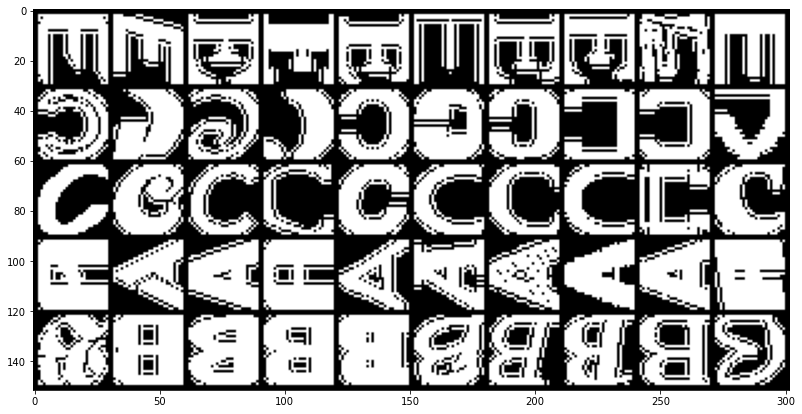

In [9]:
sample_example = extract_sample(5, 5, 5, trainx, trainy)
display_sample(sample_example['images'])

In [10]:
sample_example['images'].shape

torch.Size([5, 10, 3, 28, 28])

##Build model

Paper: [Prototypical Networks for Few-shot Learning](https://arxiv.org/pdf/1703.05175v2.pdf)

The embedding part takes a (28x28x1) image and returns a column vector of length 64. The image2vector function is composed of 4 modules. Each module comprises a 64-filter 3 × 3 convolution, a batch normalization layer, a ReLU nonlinearity and a 2 × 2 max-pooling layer. 

When applied to the 28 × 28 Omniglot images this architecture results in a 64-dimensional output space.

In [16]:
class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()

  def forward(self, x):
    return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):
  """
  Loads the prototypical network model
  Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
  Returns:
      Model (Class ProtoNet)
  """
  x_dim = kwargs['x_dim']
  hid_dim = kwargs['hid_dim']
  z_dim = kwargs['z_dim']

  def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
#         nn.Dropout(0.2),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )
    
  encoder = nn.Sequential(
    conv_block(x_dim[0], hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, z_dim),
    Flatten()
    )
    
  return ProtoNet(encoder)

In [17]:
class ProtoNet(nn.Module):
  def __init__(self, encoder):
    """
    Args:
        encoder : CNN encoding the images in sample
        n_way (int): number of classes in a classification task
        n_support (int): number of labeled examples per class in the support set
        n_query (int): number of labeled examples per class in the query set
    """
    super(ProtoNet, self).__init__()
    self.encoder = encoder.cuda()

  def set_forward_loss(self, sample):
    """
    Computes loss, accuracy and output for classification task
    Args:
        sample (torch.Tensor): shape (n_way, n_support+n_query, (dim)) 
    Returns:
        torch.Tensor: shape(2), loss, accuracy and y_hat
    """
    sample_images = sample['images'].cuda()
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:]
   
    #target indices are 0 ... n_way-1
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = Variable(target_inds, requires_grad=False)
    target_inds = target_inds.cuda()
   
    #encode images of the support and the query set
    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
   
    z = self.encoder.forward(x)
    z_dim = z.size(-1) #usually 64
    z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
    z_query = z[n_way*n_support:]

    #compute distances
    dists = euclidean_dist(z_query, z_proto)
    
    #compute probabilities
    log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)
   
    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
   
    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat
        }

In [18]:
def euclidean_dist(x, y):
  """
  Computes euclidean distance btw x and y
  Args:
      x (torch.Tensor): shape (n, d). n usually n_way*n_query
      y (torch.Tensor): shape (m, d). m usually n_way
  Returns:
      torch.Tensor: shape(n, m). For each query, the distances to each centroid
  """
  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  return torch.pow(x - y, 2).sum(2)

##Train

In [19]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
  """
  Trains the protonet
  Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
  """
  #divide the learning rate by 2 at each epoch, as suggested in paper
  scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
  epoch = 0 #epochs done so far
  stop = False #status to know when to stop
  history_loss = []
  hisrtoy_acc = []
  epochs = [1000, 2000, 3000, 4000,5000,6000,7000,8000,9000,10000]

  while epoch < max_epoch and not stop:
    running_loss = 0.0
    running_acc = 0.0

    for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
      sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
      optimizer.zero_grad()
      loss, output = model.set_forward_loss(sample)
      running_loss += output['loss']
      running_acc += output['acc']
      loss.backward()
      optimizer.step()
    epoch_loss = running_loss / epoch_size
    epoch_acc = running_acc / epoch_size
    print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
    history_loss.append(epoch_loss)
    hisrtoy_acc.append(epoch_acc)

    epoch += 1
    scheduler.step()
    
    
  plt.plot(epochs, history_loss, 'g', label='Training Loss')
  plt.plot(epochs, hisrtoy_acc, 'b', label='accuracy')
  plt.title(f"Training Loss + Accuracy \n with parameters n_support: {n_support},n_query: {n_query} ")
  plt.xlabel('Epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

<ipython-input-73-3e4a1107440d>:27: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1 -- Loss: 0.1882 Acc: 0.9429


Epoch 2 train:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2 -- Loss: 0.0919 Acc: 0.9701


Epoch 3 train:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3 -- Loss: 0.0711 Acc: 0.9767


Epoch 4 train:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4 -- Loss: 0.0545 Acc: 0.9813


Epoch 5 train:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5 -- Loss: 0.0422 Acc: 0.9860


Epoch 6 train:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 6 -- Loss: 0.0388 Acc: 0.9876


Epoch 7 train:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 7 -- Loss: 0.0361 Acc: 0.9879


Epoch 8 train:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 8 -- Loss: 0.0335 Acc: 0.9889


Epoch 9 train:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 9 -- Loss: 0.0343 Acc: 0.9891


Epoch 10 train:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 10 -- Loss: 0.0313 Acc: 0.9900


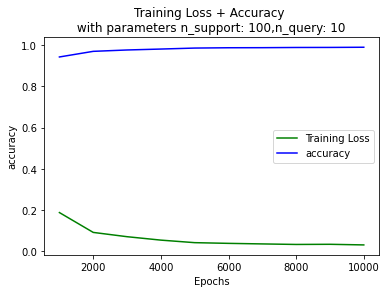

Wall time: 17min 49s


In [89]:
%%time

model = load_protonet_conv(
    x_dim=(3,28,28),
    hid_dim=64,
    z_dim=64,
    )

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 5
n_support = 100
n_query = 10

train_x = trainx
train_y = trainy

max_epoch = 10
epoch_size = 1000

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

##Test

In [90]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode, epoch_size):
  """
  Tests the protonet
  Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
  """
  history_loss = []
  hisrtoy_acc = []
  epoch = 0 #epochs done so far
  epochs = [200, 400, 600, 800,1000,1200,1400,1600,1800,2000]
  running_loss = 0.0
  running_acc = 0.0
    
  while epoch < epoch_size:
    running_loss = 0.0
    running_acc = 0.0
    for episode in tnrange(test_episode):
      sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
      loss, output = model.set_forward_loss(sample)
      running_loss += output['loss']
      running_acc += output['acc']
    avg_loss = running_loss / test_episode
    avg_acc = running_acc / test_episode
    history_loss.append(avg_loss)
    hisrtoy_acc.append(avg_acc)
    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))
    epoch += 1


  plt.plot(epochs, history_loss, 'g', label='Test Loss')
  plt.plot(epochs, hisrtoy_acc, 'b', label='average accuracy')
  plt.title(f"Test Loss + Accuracy \n with parameters n_support: {n_support}, n_query: {n_query} ")
  plt.xlabel('Epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

<ipython-input-90-9a13c5e68f46>:23: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(test_episode):


  0%|          | 0/200 [00:00<?, ?it/s]

Test results -- Loss: 0.2999 Acc: 0.8842


  0%|          | 0/200 [00:00<?, ?it/s]

Test results -- Loss: 0.2970 Acc: 0.8917


  0%|          | 0/200 [00:00<?, ?it/s]

Test results -- Loss: 0.3025 Acc: 0.8956


  0%|          | 0/200 [00:00<?, ?it/s]

Test results -- Loss: 0.3070 Acc: 0.8870


  0%|          | 0/200 [00:00<?, ?it/s]

Test results -- Loss: 0.3141 Acc: 0.8827


  0%|          | 0/200 [00:00<?, ?it/s]

Test results -- Loss: 0.2977 Acc: 0.8908


  0%|          | 0/200 [00:00<?, ?it/s]

Test results -- Loss: 0.2911 Acc: 0.8944


  0%|          | 0/200 [00:00<?, ?it/s]

Test results -- Loss: 0.2832 Acc: 0.8939


  0%|          | 0/200 [00:00<?, ?it/s]

Test results -- Loss: 0.3044 Acc: 0.8898


  0%|          | 0/200 [00:00<?, ?it/s]

Test results -- Loss: 0.3066 Acc: 0.8844


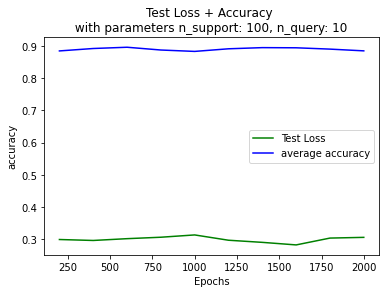

In [92]:
n_way = 5
n_support = 100
n_query = 10

test_x = testx
test_y = testy

test_episode = 200
epoch_size = 10
test(model, test_x, test_y, n_way, n_support, n_query, test_episode, epoch_size)

##Test on specific example

Let's test the model on a specific example to visualize how well does it label the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


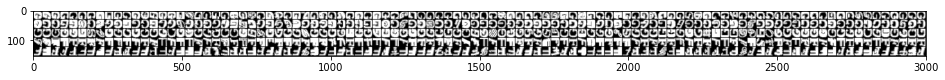

In [27]:
my_sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

In [28]:
my_loss, my_output = model.set_forward_loss(my_sample)

In [29]:
my_output

{'loss': 0.05194079130887985,
 'acc': 0.9899999499320984,
 'y_hat': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
         [3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
         [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]],
        device='cuda:0')}